Exploratory Data Analysis (EDA)

Loading packages

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
plt.rcParams.update({'font.size': 22})

In [51]:
# Load CSV file
file_path = "../Data/allOrgan.csv"  # Replace with your actual file path
data = pd.read_csv(file_path)
# Preview the data
print(data.head())

   isBourdon  flueDepth  frequency  cutUpHeight  diameterToe  \
0        0.0    0.00035      196.0       0.0105       0.0070   
1        0.0    0.00035      196.0       0.0105       0.0085   
2        0.0    0.00106      146.8       0.0120       0.0070   
3        0.0    0.00106      138.6       0.0120       0.0085   
4        0.0    0.00060      174.6       0.0100       0.0072   

   acousticIntensity  partial1  partial2  partial3  partial4  partial5  \
0               73.0      99.0      61.0      87.0      37.0      44.0   
1               90.0      70.0      99.0      73.0      18.0      13.0   
2               65.0      91.0      43.0      99.0      52.0      69.0   
3               86.0      11.0       0.0      99.0       3.0       0.0   
4               87.0      44.0       0.0      99.0      13.0      52.0   

   partial6  partial7  partial8  
0       0.0       5.0       0.0  
1       0.0       5.0       0.0  
2      40.0      50.0      19.0  
3       0.0       0.0       0.0  


Exploratory Data Analysis (EDA)
Several key factors affect the pipe's sound:
	Air pressure (wind): Determines the power of the tone (Pa).
	Frequency (pitch): Sets the note being played (Hz).
	Flow rate: Depends on the size of the toe-hole (m^3/s).
	Flue size: Shapes the airflow and tone quality (m).
	Cut-up height: Impacts the tone’s brightness and balance (m).
	Air density: Influences sound production (kg
/m^3).
The Ising formula provides a way to calculate the ideal tone, but it doesn’t include a key element, which is flow rate (toe-hole size), which is crucial for controlling tonal results. Measurements show that pipes may overblow—producing higher pitches like octaves—earlier than predicted by the formula. This project aims to enhance the Ising formula by incorporating flow rate, thereby creating a more reliable method for producing and prevoicing organ pipes in industrial s
ettings.
In the initial stage of data wrangling, we exclude constants and parameters that can be readily derived through computational methods. Instead, we prioritize key variables that require direct physical measurement, including flue depth, frequency, cut-up height, acoustic intensity, and toe diameter. Subsequently, we formulate equations to compute flow rate, Ising numbers, and modified Ising numbers incorporating flow rate.
Let use Matplotlib, (Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90-95. https://doi.org/10.1109/MCSE.2007.55
), a popular library for data visualization, to create bar charts for the amplitudes of each partial in the first 19 observations. This is to give us a general idea of what the amplitude generally looks like in most of the obervations.


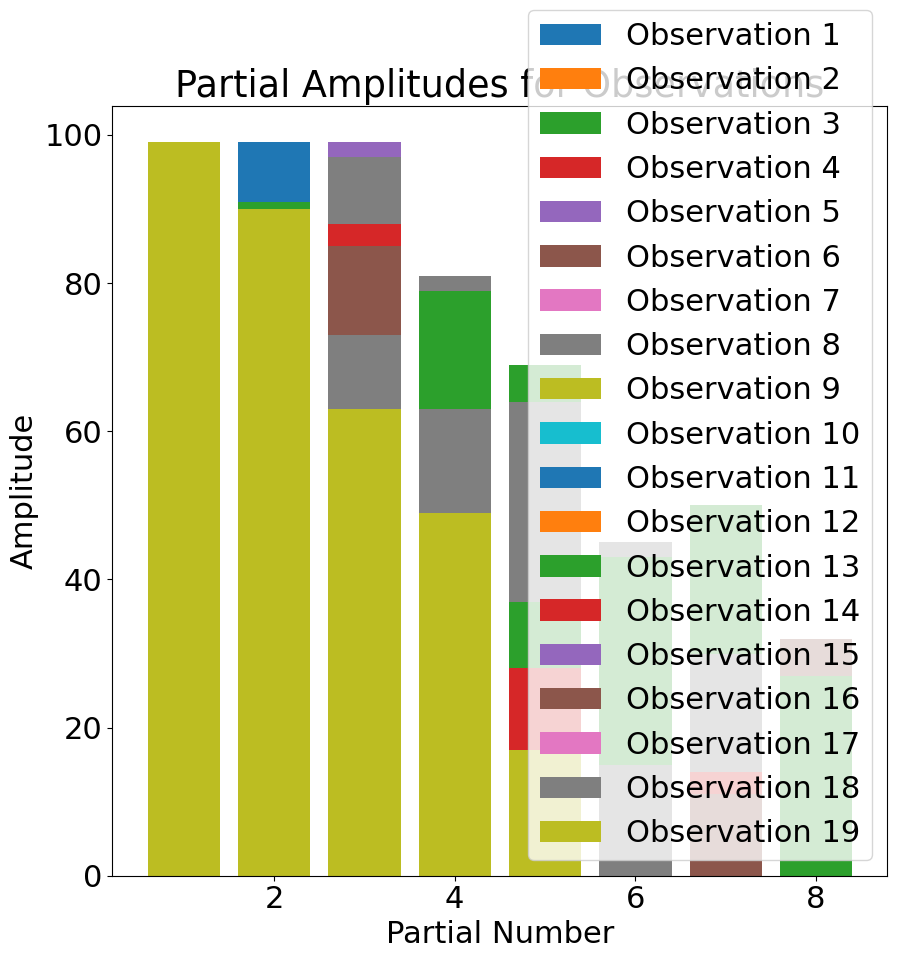

In [52]:
partials = data[['partial1', 'partial2', 'partial3', 'partial4', 
                 'partial5', 'partial6', 'partial7', 'partial8']].values
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(19):
    ax.bar(range(1, 9), partials[i], alpha= 1, label=f'Observation {i+1}')
ax.set_xlabel('Partial Number')
ax.set_ylabel('Amplitude')
ax.set_title('Partial Amplitudes for Observations')
ax.legend()
plt.show()

Let use Matplotlib, (Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90-95. https://doi.org/10.1109/MCSE.2007.55
), a popular library for data visualization, to create bar charts for the amplitudes of each partial in the first 19 observations. This is to give us a general idea of what the amplitude generally looks like in most of the observations.
We extract data-- select specific columns (partial1 to partial8) from a Data Frame. Then, converting the selected portion into a NumPy array, set up the size for the bar plot, and create a loop that iterates i from 0 to 18, while it plots 8 partials for each observation.

An ideal pipe should produce amplitudes close to the following graph:

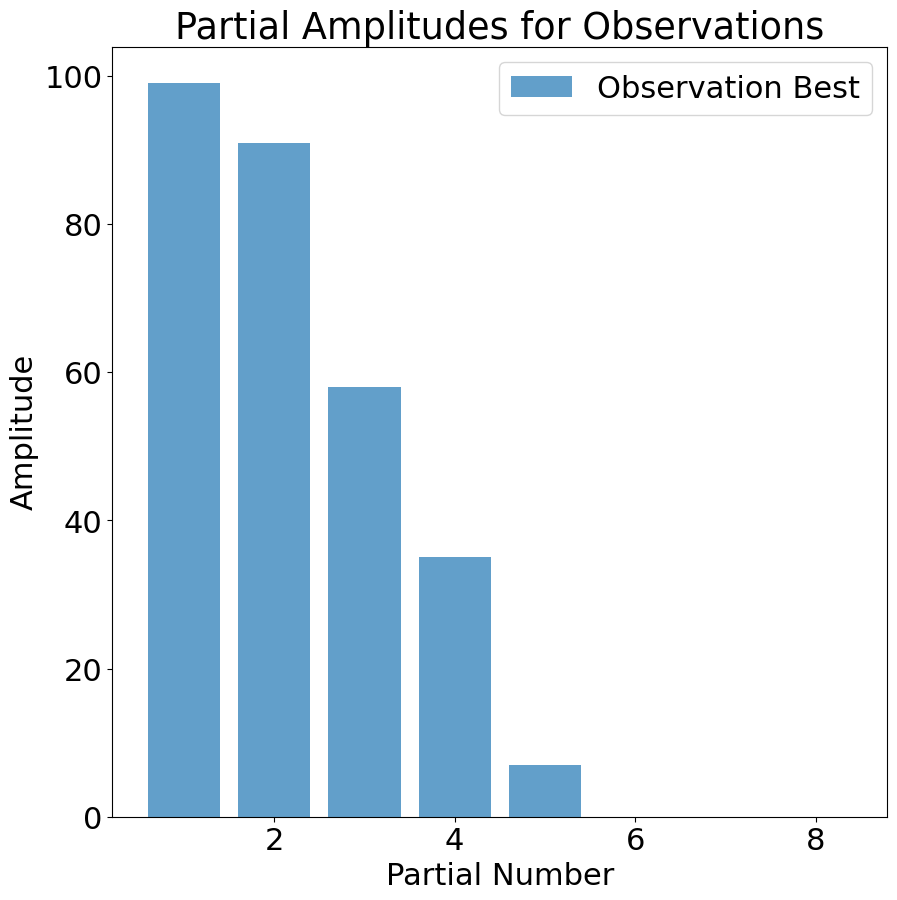

In [53]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.bar(range(1, 9), partials[41], alpha=0.7, label='Observation Best')
ax.set_xlabel('Partial Number')
ax.set_ylabel('Amplitude')
ax.set_title('Partial Amplitudes for Observations')
ax.legend()
plt.show()

In [54]:
# Define features and target (partials)
X = data[['flueDepth', 'frequency', 'cutUpHeight', 'acousticIntensity', 'diameterToe']]
y = data[['partial1', 'partial2', 'partial3', 'partial4', 
          'partial5', 'partial6', 'partial7', 'partial8']]
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train a simple model
model = LinearRegression()
model.fit(X_train, y_train)
# Predict partials
predicted_partials = model.predict(X_test)

With the constant value of P = 0.77 Pa and RHO (air density) = 1.185 kg/m^3 . We calculated the predicted Ising, toe area, and flow rate as follows:
Toe area = π⋅(D/2)^2
Flow rate = d^2.√P
Ising = √ (2P↓*D)/ (ρ*H3))/Q
Correlation Analysis 
Correlation matrix (Matplotlib 3.10.3 documentation) can help us understand the relationship between two or more variables in the dataset. In this case, analyzing how flow rate affects predicted Ising values, I may see if airflow plays a major role in tonal stability. Then, we use a scatterplot to visualize the Correlation Matrix.


In [55]:
#Using Z-score Filtering to eliminate outliners 

Filtered Correlation Matrix:
             flow_rate  predicted_I
flow_rate     1.000000    -0.218468
predicted_I  -0.218468     1.000000


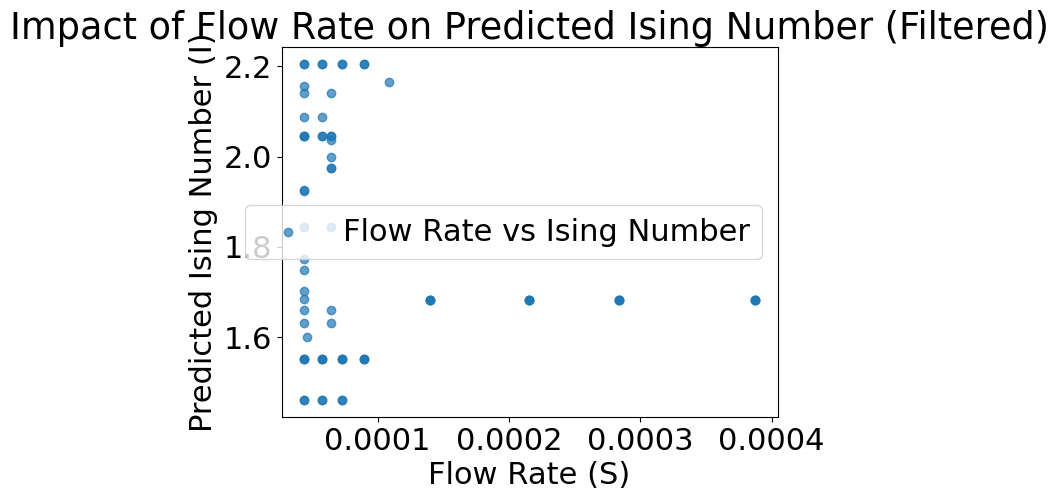

In [56]:
P = 0.77  # Constant wind pressure (inches of water column)
RHO = 1.185  # Air density (kg/m³)
# Calculate predicted Ising values
def ising_formula(flueDepth, cutUpHeight, frequency):
    return np.sqrt(((2 * P * flueDepth) / (RHO * (cutUpHeight**3))))/ frequency * 10
data['predicted_I'] = ising_formula(data['flueDepth'], data['cutUpHeight'], data['frequency'])
data['toe_area'] = np.pi * (data['diameterToe'] / 2)**2  # Cross-sectional area of toe-hole
data['flow_rate'] = data['toe_area'] * 1.14  # Flow rate (S)

filtered_data = data[(np.abs(stats.zscore(data[['flow_rate', 'predicted_I']])) < 1.5).all(axis=1)]

correlation = filtered_data[['flow_rate', 'predicted_I']].corr()
print("Filtered Correlation Matrix:")
print(correlation)

plt.scatter(filtered_data['flow_rate'], filtered_data['predicted_I'], alpha=0.7, label='Flow Rate vs Ising Number')
plt.xlabel('Flow Rate (S)')
plt.ylabel('Predicted Ising Number (I)')
plt.title('Impact of Flow Rate on Predicted Ising Number (Filtered)')
plt.legend()
plt.show()


In [57]:
#Perform a regression analysis to explicitly model the relationship between 𝑆
#and 𝐼. This can quantify the exact impact of flow rate on tonal stability.

In [58]:
X = data[['flow_rate']].values  # Flow rate as the independent variable
y = data['predicted_I'].values  # Predicted Ising number as the dependent variable

regressor = LinearRegression()
regressor.fit(X, y)
print(f"Regression Coefficient (Flow Rate Impact on I): {regressor.coef_[0]}")

Regression Coefficient (Flow Rate Impact on I): 0.006144278442691465


In [59]:
#A coefficient close to zero suggests that while flow rate has some effect on 𝐼
#, its influence is relatively weak compared to other factors 
#like cut-up height (𝐻), flue dimension (𝐷), or frequency (𝑄).

In [60]:
#Geometric Relationships:

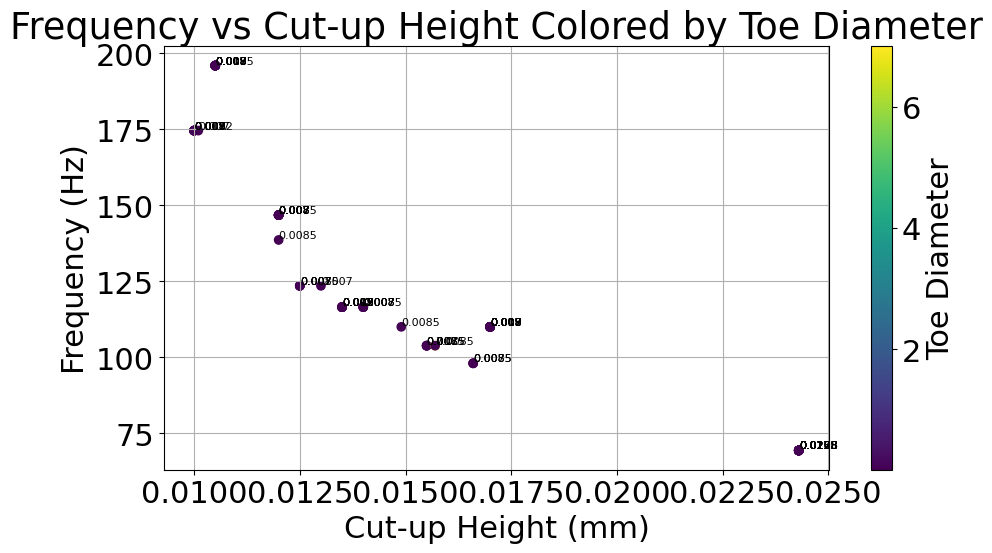

In [61]:
# Relationship between cut-up height and frequency
plt.figure(figsize=(10,6))
scatter = plt.scatter(data['cutUpHeight'], data['frequency'], c=data['diameterToe'], cmap='viridis')

# Add colorbar
plt.colorbar(label='Toe Diameter')

# Annotate each point with its diameterToe value
for i, txt in enumerate(data['diameterToe']):
    plt.text(data['cutUpHeight'][i], data['frequency'][i], str(txt), fontsize=8, ha='left', va='bottom', color='black')

# Labels and title
plt.xlabel('Cut-up Height (mm)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency vs Cut-up Height Colored by Toe Diameter')

# Improve visibility
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


Here, we are using another graphing technique (Matplotlib 3.10.3 documentation) showing the relationship between frequency and cut-up height. As the cut-up height increases, the frequency decreases. And the toe diameter stays as the smallest value below 1.

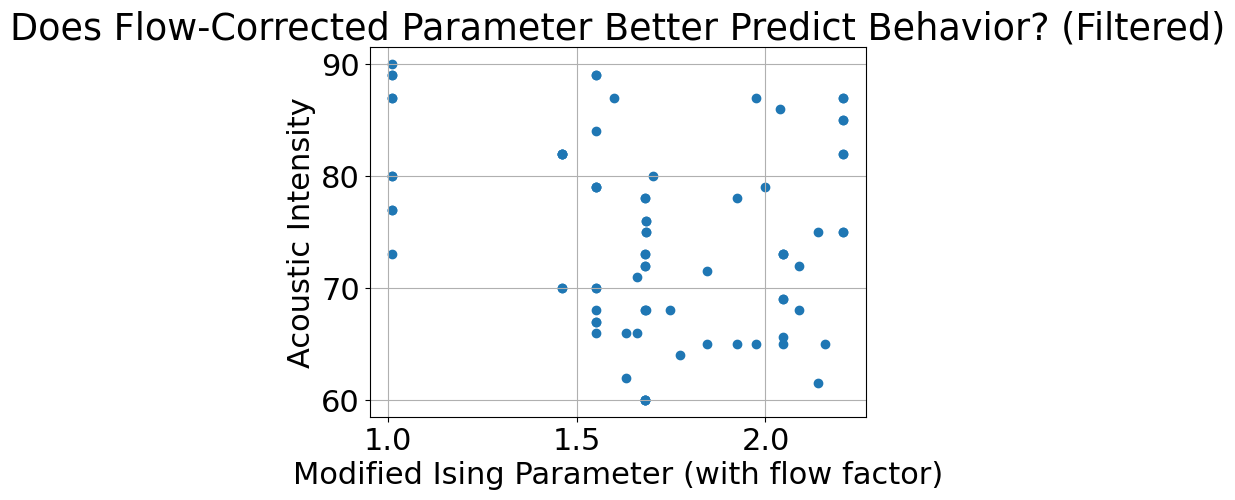

Filtered Correlation Matrix:
                   modified_ising  acousticIntensity
modified_ising           1.000000          -0.234884
acousticIntensity       -0.234884           1.000000


In [62]:
#Modified Ising Parameter with Flow Rate:
#Calculate flow rate contribution (simplified)
data['flow_factor'] = data['diameterToe']**2 * np.sqrt(P)

# Create modified Ising parameter
data['modified_ising'] = data['predicted_I'] * (1 + 0.5*data['flow_factor'])

# Compute Z-scores for relevant variables
z_scores = np.abs(stats.zscore(data[['modified_ising', 'acousticIntensity']]))

# Filter data to exclude outliers (Z-score threshold of 3)
filtered_data = data[(z_scores < 3).all(axis=1)]

# Scatter plot after filtering outliers
plt.scatter(filtered_data['modified_ising'], filtered_data['acousticIntensity'])
plt.xlabel('Modified Ising Parameter (with flow factor)')
plt.ylabel('Acoustic Intensity')
plt.title('Does Flow-Corrected Parameter Better Predict Behavior? (Filtered)')
plt.grid(True)
plt.show()

correlation = filtered_data[['modified_ising', 'acousticIntensity']].corr()
print("Filtered Correlation Matrix:")
print(correlation)

There is a weak relationship detected. When the acoustic intensity increases, the modified Ising parameter decreases. The purpose of plotting Acoustic Intensity and Modified Ising Parameters is to test whether flow-corrected predictions align better with real-world sound measurements. If the modified Ising value shows a stronger correlation with acoustic intensity, it suggests that flow rate should be considered in tonal stability models. However, in this case, we failed to prove that since we did not have enough data.

In [63]:
#The feature importance results show that cutUpHeight dominates (98.6%) the frequency prediction, 
#while flueDepth and diameterToe have minimal impact (1.3% and 0.1% respectively)

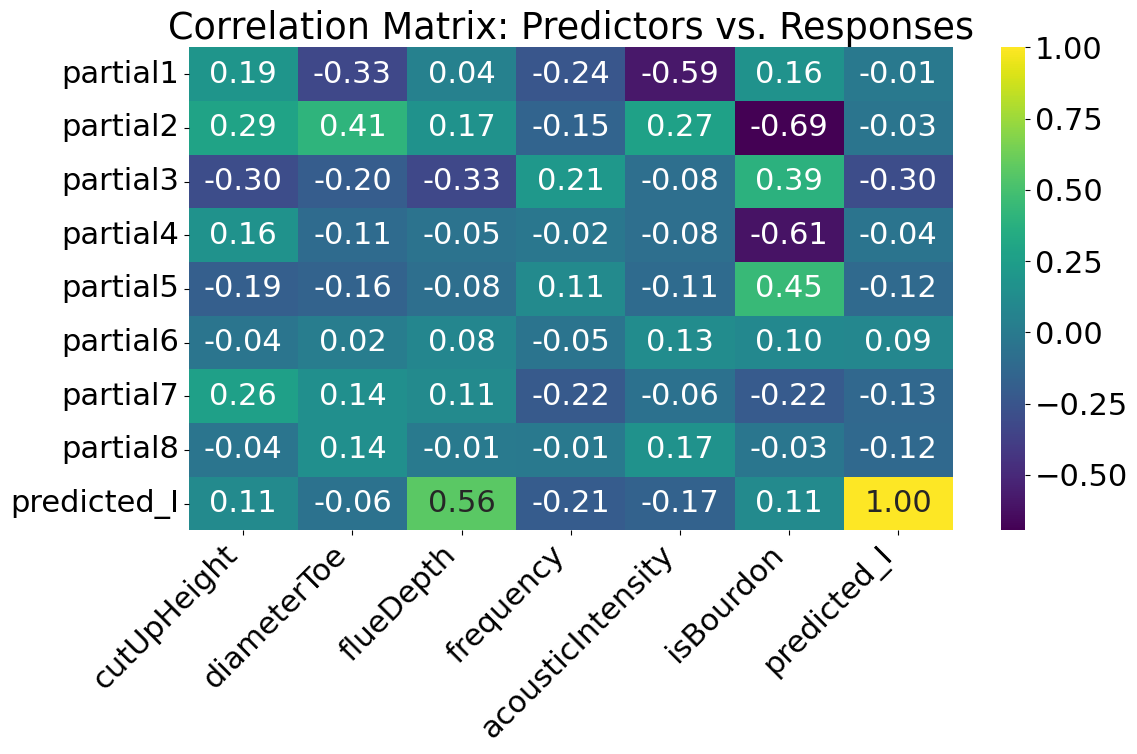

In [64]:
# 1. Create fresh copy of original data without interval categories
working_data = data.copy()

# 2. Create dimensionless groups (using original numeric columns)
working_data['cutup_to_diameter'] = working_data['cutUpHeight'] / working_data['diameterToe']
working_data['flue_to_cutup'] = working_data['flueDepth'] / working_data['cutUpHeight']

# 3. Define predictors (X) and responses (Y)
predictors = ['cutUpHeight', 'diameterToe', 'flueDepth', 'frequency', 'acousticIntensity', 'isBourdon']
responses = [col for col in working_data.columns if 'partial' in col]

# 4. Ensure correlation matrix includes only predictors and responses
correlation_data = working_data[predictors + responses + ['predicted_I']]

# 5. Calculate correlation matrix and filter rows to only responses
correlation_matrix = correlation_data.corr(method='spearman').loc[responses+ ['predicted_I'] , predictors+ ['predicted_I']]  # Only responses on y-axis

# 6. Improved visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='viridis',
            fmt='.2f')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Matrix: Predictors vs. Responses')
plt.tight_layout()
plt.savefig('PR.png')
plt.show()

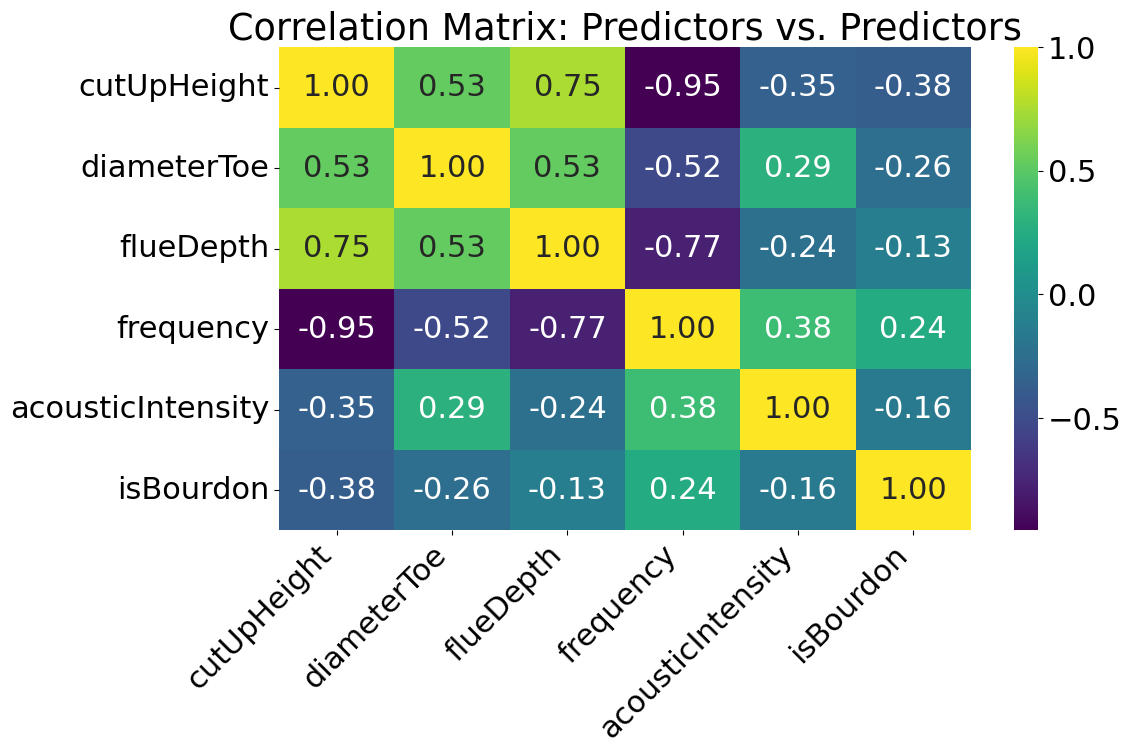

In [65]:
correlation_matrix = correlation_data.corr(method='spearman').loc[predictors, predictors]  # Only responses on y-axis

# 6. Improved visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='viridis',
            fmt='.2f')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Matrix: Predictors vs. Predictors')
plt.tight_layout()
plt.savefig('PP.png')
plt.show()